# UberEats - Text recognition using CTPN

In [1]:
# Imports
import os
import shutil
import sys
import time

import cv2
import numpy as np
import tensorflow as tf
from IPython.core import display

In [2]:
from nets import model_train as model
from utils.rpn_msr.proposal_layer import proposal_layer
from utils.text_connector.detectors import TextDetector

In [3]:
# Global Variables
output_path = "output" 
image_path = "data/txtrecog/sample_2.png"
checkpoint_path = "models/checkpoints_mlt"
GPU = "0"

In [4]:
"""
"""
def resize_image(img):
    # get original image size
    img_size = img.shape
    
    # Get max and min size of image
    im_size_min = np.min(img_size[0:2])
    im_size_max = np.max(img_size[0:2])
    
    # scale the image
    im_scale = float(600) / float(im_size_min)
    if np.round(im_scale * im_size_max) > 1200:
        im_scale = float(1200) / float(im_size_max)
        
    # New image height and width
    new_h = int(img_size[0] * im_scale)
    new_w = int(img_size[1] * im_scale)

    new_h = new_h if new_h // 16 == 0 else (new_h // 16 + 1) * 16
    new_w = new_w if new_w // 16 == 0 else (new_w // 16 + 1) * 16
    
    # resize the image
    re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    return re_im, (new_h / img_size[0], new_w / img_size[1])

Restore from models/checkpoints_mlt/ctpn_50000.ckpt
INFO:tensorflow:Restoring parameters from models/checkpoints_mlt/ctpn_50000.ckpt
data/txtrecog/sample_2.png


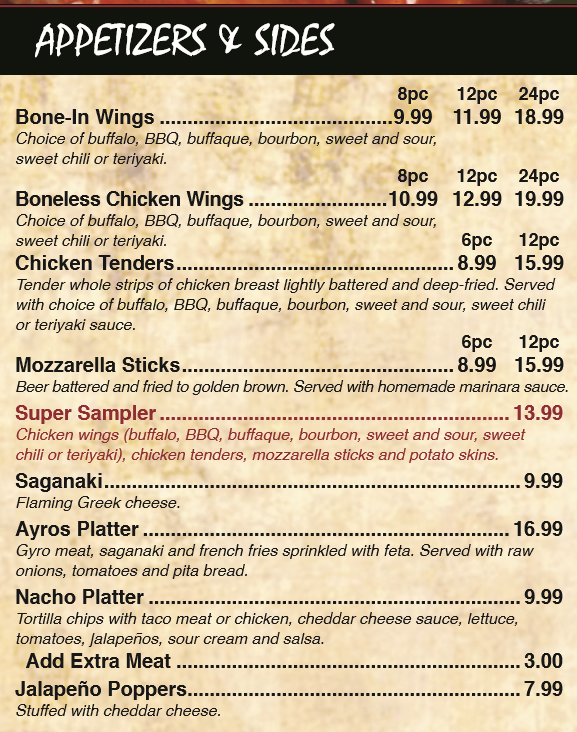

cost time: 2.90s


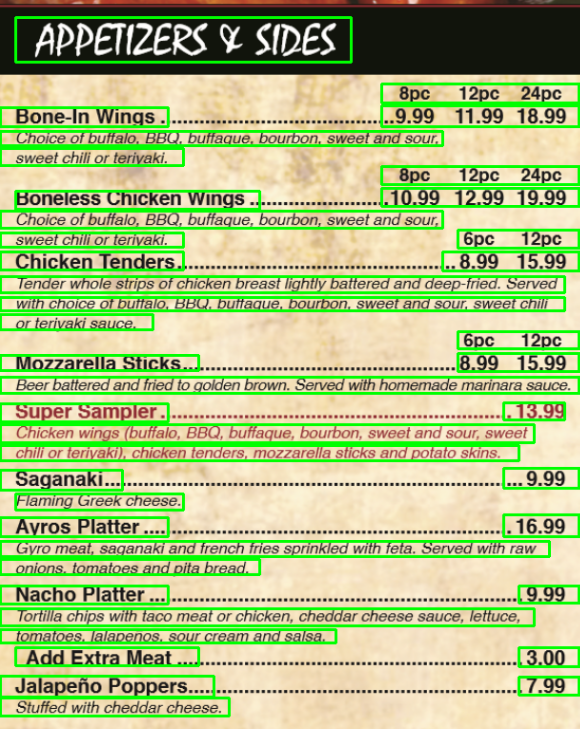

In [5]:
with tf.get_default_graph().as_default():
    input_image = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_image')
    input_im_info = tf.placeholder(tf.float32, shape=[None, 3], name='input_im_info')
    
    global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
    
    bbox_pred, cls_pred, cls_prob = model.model(input_image)
    
    variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
    saver = tf.train.Saver(variable_averages.variables_to_restore())
    
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        ckpt_state = tf.train.get_checkpoint_state(checkpoint_path)
        model_path = os.path.join(checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
        print('Restore from {}'.format(model_path))
        
        saver.restore(sess, model_path)
        
        im_fn_list = []
        im_fn_list.append(image_path)
        for im_fn in im_fn_list:
            print('===============')
            print(im_fn)
            display.display(display.Image(im_fn))
            start = time.time()
            try:
                im = cv2.imread(im_fn)[:, :, ::-1]
            except:
                print("Error reading image {}!".format(im_fn))
                continue
            img, (rh, rw) = resize_image(im)
            h, w, c = img.shape
            im_info = np.array([h, w, c]).reshape([1, 3])
            bbox_pred_val, cls_prob_val = sess.run([bbox_pred, cls_prob],
                                                   feed_dict={input_image: [img],
                                                              input_im_info: im_info})

            textsegs, _ = proposal_layer(cls_prob_val, bbox_pred_val, im_info)
            scores = textsegs[:, 0]
            textsegs = textsegs[:, 1:5]

            textdetector = TextDetector(DETECT_MODE='H')
            boxes = textdetector.detect(textsegs, scores[:, np.newaxis], img.shape[:2])
            boxes = np.array(boxes, dtype=np.int)

            cost_time = (time.time() - start)
            print("cost time: {:.2f}s".format(cost_time))

            for i, box in enumerate(boxes):
                cv2.polylines(img, [box[:8].astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 255, 0),
                              thickness=2)
            img = cv2.resize(img, None, None, fx=1.0 / rh, fy=1.0 / rw, interpolation=cv2.INTER_LINEAR)
            cv2.imwrite(os.path.join(output_path, os.path.basename(im_fn)), img[:, :, ::-1])
            new_img = os.path.join(output_path, os.path.basename(im_fn))
            display.display(display.Image(new_img))

            with open(os.path.join(output_path, os.path.splitext(os.path.basename(im_fn))[0]) + ".txt",
                      "w") as f:
                for i, box in enumerate(boxes):
                    line = ",".join(str(box[k]) for k in range(8))
                    line += "," + str(scores[i]) + "\r\n"
                    f.writelines(line)